# World of Julia

*Updated: 2015-09-14*

*Jiahao Chen, MIT*

Have you ever wondered who contributes to Julia? This notebook explores basic facets of the Julia community.

First, load up a bunch of packages written by the Julia community.

In [1]:
if false #Change to true to install missing packages
    Pkg.update()
    for pkg in ["Compat", "Compose", "Gadfly", "GitHub", "JLD", "JSON",
            "Interact", "MetadataTools", "ProgressMeter", "Requests", "Shapefile",
            "URIParser"]
        Pkg.installed(pkg)==nothing && Pkg.add(pkg)
    end
    Pkg.checkout("Shapefile") #See JuliaGeo/Shapefile.jl/issues/9
end

In [2]:
using Compat
using Compose
using Gadfly
using GitHub
using JLD
using JSON
using Interact
using MetadataTools
using ProgressMeter
using Requests
using Shapefile
using URIParser

Next, authenticate a GitHub access token for reading data from GitHub.

Substitute your own token by following [these instructions](https://help.github.com/articles/creating-an-access-token-for-command-line-use/). Select **public_repo** and **user** for scopes.

In [3]:
auth_token="" #to access Github API
my_auth = authenticate(auth_token)

GitHub Authorization (a3c5d0**********************************)

In [4]:
isfile("worldofjulia.jld") && load("worldofjulia.jld")

Dict{ByteString,Any} with 5 entries:
  "locations"         => Dict{Any,Any}("tlamadon"=>(41.8755546,-87.6244212,"Chi…
  "juliastargazers"   => [GitHub.User - brixen,GitHub.User - daksis,GitHub.User…
  "juliawatchers"     => [GitHub.User - johnmyleswhite,GitHub.User - pao,GitHub…
  "juliacontributors" => [Dict{Any,Any}("author"=>GitHub.User - JeffBezanson,"c…
  "allcontributors"   => [Dict{Any,Any}("author"=>GitHub.User - JeffBezanson,"c…

# The main Julia repository

Let's start with the main repository.

In [5]:
authors=contributors("JuliaLang", "julia", auth=my_auth)
println("$(length(authors)) contributors found for JuliaLang/julia")

402 contributors found for JuliaLang/julia


## An avatar montage

GitHub provides detailed information about user profiles.

One fun thing to do is to download everyone's [profile pictures](https://help.github.com/articles/how-do-i-set-up-my-profile-picture/) and turn them into a montage using [ImageMagick](http://www.imagemagick.org).

Julia provides a native `download` function, which is convenient but forks an external command such as `curl` or `wget` each time it is run. To download many small files, it is more convenient to use `Requests.jl`.

`dl` below is a basic working replacement for `download`.

In [6]:
#Download data from a given URL to a file.
function dl(url::String, filename::String, tries = 3)
    isfile(filename) && return #Don't overwrite existing files
    r = nothing
    for i=1:tries
        try
            r = get(url)
            r.status == 200 && break

            if contains(r.headers["Content-Type"], "text/html")
                display("text/html", r.data)
            end
            r.status == 302 && break #Redirection
        catch end
        sleep(3)
    end
    if r.status == 200
        open(filename, "w") do f
            write(f, r.data)
        end
    else
        warn("Could not download $url\nStatus: $(r.status)")
    end
end

dl (generic function with 2 methods)

Next, use `dl` to download the avatars associated with an iterable collection of authors. We also use ImageMagick's `mogrify` command to automatically resize each avatar file to 64x64 pixels.

`getavatars` can take awhile, so we use `ProgressMeter.@showprogress` to show a progress bar for the main loop over the `authors`.

In [7]:
#Download everyone's avatars
function getavatars(authors)
    avatarfiles = Dict()
    @showprogress for author in authors
        login = author["author"].login
        url = author["author"].avatar_url
        if !haskey(avatarfiles, login)
            avatarfilename = string(login, ".png")
            dl(url, avatarfilename)
            run(`mogrify -resize 64x64 $avatarfilename`)
            avatarfiles[login] = avatarfilename
        end
    end
    avatarfiles
end
avatarfiles = getavatars(authors)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Dict{Any,Any} with 402 entries:
  "agoddard"        => "agoddard.png"
  "davidkh"         => "davidkh.png"
  "cameyo42"        => "cameyo42.png"
  "JeffBezanson"    => "JeffBezanson.png"
  "rmyorston"       => "rmyorston.png"
  "dancasimiro"     => "dancasimiro.png"
  "schenker"        => "schenker.png"
  "pniang"          => "pniang.png"
  "julian-gehring"  => "julian-gehring.png"
  "cicku"           => "cicku.png"
  "catawbasam"      => "catawbasam.png"
  "GunnarFarneback" => "GunnarFarneback.png"
  "autozimu"        => "autozimu.png"
  "goretkin"        => "goretkin.png"
  "doomsplayer"     => "doomsplayer.png"
  "PallHaraldsson"  => "PallHaraldsson.png"
  "garrison"        => "garrison.png"
  "randyzwitch"     => "randyzwitch.png"
  "peterdn"         => "peterdn.png"
  "doowttam"        => "doowttam.png"
  "cbecker"         => "cbecker.png"
  "patrickyevsukov" => "patrickyevsukov.png"
  "shashi"          => "shashi.png"
  "dcampbell24"     => "dcampbell24.png"
  "jdrugo"          =

Finally, use [ImageMagick's](http://www.imagemagick.org) `montage` to create a montage of contributors to the main `julia` repository using their GitHub avatars. Each avatar can also be sorted and annotated by the number of commits to the repository.

(Note: For faster performance, make sure ImageMagick is compiled with the [OpenMP Feature](http://www.imagemagick.org/script/openmp.php).)

In [8]:
function makemontage(filename, authors, avatarfiles; layout=nothing)
    cmd = `montage`
    layout==nothing || (cmd = `$cmd -tile $(layout[1])x$(layout[2])`)
    for author in sort(authors, by=x->x["contributions"], rev=true)
        login, contribs = author["author"].login, author["contributions"]
        if !haskey(avatarfiles, login)
            warn("Skipping user $login: no associated entry in avatarfiles")
            continue
        end

        avatarfile = avatarfiles[login]
        if !isfile(avatarfile)
            warn("Skipping user $login: no file $avatarfile")
            continue
        end
        cmd = `$cmd -label "$login\n($contribs)" $avatarfile`
    end
    cmd = `$cmd -geometry 64x64+16+16 -font Calibri $filename`
    run(cmd)
end

makemontage (generic function with 1 method)

In [9]:
#Compute montage layout
aspectratio = φ #Golden ratio
ntiles=√(length(authors)/aspectratio)
ntilesx, ntilesy = ceil(Int, aspectratio*ntiles), ceil(Int, ntiles)

(26,16)

In [10]:
@async makemontage("montage_juliaonly.jpg", authors, avatarfiles,
    layout = (ntilesx, ntilesy))

Task (waiting) @0x00000001104e5900

<img src="montage_juliaonly.jpg"/>

# Including Julia packages

Julia has a rapidly growing list of [registered packages](http://pkg.julialang.org/) which represent the efforts of yet more developers. We can make another montage of contributors, this time including all package authors also.

Use the built-in `Pkg` module to get a list of available packages, then use `MetadataTools.get_pkg` to retrieve all the associated package metadata and retrieve the GitHub owners and repository names using `URIParser.parse_url`.

In [11]:
#Scan package metadata and get URLs for all registered packages
Packages = Tuple{AbstractString, AbstractString}[]
@showprogress for pkg in Pkg.available()
    url = get_pkg(pkg).url
    path = URIParser.parse_url(url).path
    _, owner, repo = split(path, '/')
    repo = split(repo, ".git")[1]
    push!(Packages, (owner, repo))
end
println("$(length(Packages)) packages found.")

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Now we can query each package's GitHub repository for its corresponding list of contributors and commit counts, merging the contribution counts back into `authors` for a total count across all the repositories.

In [12]:
#Update authors with package contributors
#Collates all the contribution counts also
juliacontributors = copy(authors)

@showprogress for (owner, repo) in Packages
    thispkg_contributors = try
        contributors(owner, repo, auth=my_auth)
    catch
        warn("Skipping $owner/$repo")
        continue
    end
    
    #Merge global statistics
    for contributor in thispkg_contributors
        authorobj = contributor["author"]
        isnew = true
        for (i, author) in enumerate(authors)
            if author["author"].login == authorobj.login
                isnew = false
                authors[i]["contributions"] += contributor["contributions"]
                break
            end
        end
        isnew && push!(authors, contributor)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
678 packages found.
Progress: 100%|█████████████████████████████████████████| Time: 0:04:04


As before, grab everyone's avatars.

In [13]:
avatarfiles = getavatars(authors)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Dict{Any,Any} with 930 entries:
  "credentiality"   => "credentiality.png"
  "lynyus"          => "lynyus.png"
  "Snnappie"        => "Snnappie.png"
  "ZacCranko"       => "ZacCranko.png"
  "benhamner"       => "benhamner.png"
  "iraikov"         => "iraikov.png"
  "schenker"        => "schenker.png"
  "GunnarFarneback" => "GunnarFarneback.png"
  "njwilson23"      => "njwilson23.png"
  "lobingera"       => "lobingera.png"
  "garrison"        => "garrison.png"
  "cgoldammer"      => "cgoldammer.png"
  "randyzwitch"     => "randyzwitch.png"
  "slangangular"    => "slangangular.png"
  "jdrugo"          => "jdrugo.png"
  "vrld"            => "vrld.png"
  "jcorbin"         => "jcorbin.png"
  "swdunlop"        => "swdunlop.png"
  "yipihey"         => "yipihey.png"
  "iancze"          => "iancze.png"
  "jey"             => "jey.png"
  "m-lohmann"       => "m-lohmann.png"
  "davidlizeng"     => "davidlizeng.png"
  "msimberg"        => "msimberg.png"
  "jlep"            => "jlep.png"
  ⋮       

And now we can make a new montage.

In [14]:
#Compute montage layout
aspectratio = φ
ntiles=√(length(authors)/aspectratio)
ntilesx, ntilesy = ceil(Int, aspectratio*ntiles), ceil(Int, ntiles)

(39,24)

In [15]:
@async makemontage("montage_julia.jpg", authors, avatarfiles,
    layout = (ntilesx, ntilesy))

Task (waiting) @0x000000010c26b9d0

<img src="montage_julia.jpg" />

# Distribution of commits

In [16]:
spacing=10
rawcounts = Int[author["contributions"] for author in authors]
uppercount=spacing*ceil(Int, maximum(rawcounts)/spacing)
grid = logspace(0, log10(uppercount), 22)
_, counts = hist(rawcounts, grid)

([1.0,1.52735,2.33281,3.56302,5.44199,8.31184,12.6951,19.3899,29.6152,45.2329  …  161.166,246.157,375.969,574.237,877.062,1339.58,2046.02,3124.99,4772.96,7290.0],[0,82,44,76,61,43,59,43,42,41  …  38,20,25,19,13,7,9,3,2,1])

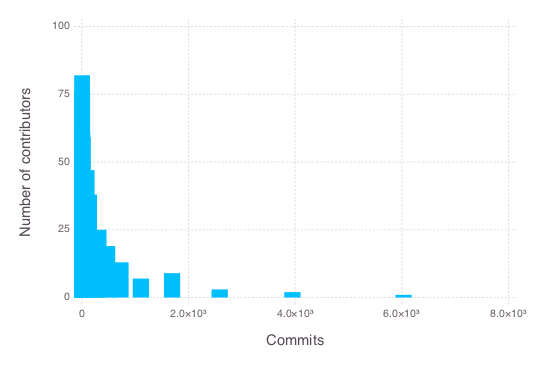

In [17]:
plot(Geom.bar, Guide.xlabel("Commits"), Guide.ylabel("Number of contributors"),
    y=counts, x=midpoints(grid))

# Plotting activity on a world map

Another thing we can do with the data is to place everyone on a world map. One way to plot a world map in Julia is to use `Shapefile.jl` to read in a shape file of the world, and render the result in `Compose.jl`.

There are two wrinkles to deal with:

1. `Compose.rectangle` uses different data to describe rectangles than `Shapefile.Rect`. The former uses `(left, top, width, height)` whereas the latter uses `(left, right, top, bottom)`. We can handle the change in data by defining a new `Compose.rectangle` constructor which takes a `Shapefile.Rect` as input.

2. A `Shapefile.Polygon` can be disjoint while a `Compose.polygon` cannot. The distinction is important when reading in shapefiles with disjoint polygons, e.g. to describe noncontiguous country borders. Here, we define a new `convert` method from the former to a `Vector` of `Compose.polygon`s. We also define our own `Polygons` function to generate a `Vector` of `polygon`s from either a `Polygon` or a `Vector` of `Polygon`s. In the latter case we convert each `Polygon` to a `Vector` of `polygon`s, then flatten the resulting `Vector` of `Vector`s after iterating through all the `Polygon`s.

In [18]:
#Convert Shapefile rectangle to Compose rectangle
Compose.rectangle{T<:Real}(R::Shapefile.Rect{T}) = rectangle(R.left,R.top,R.right-R.left,R.bottom-R.top)

#Compose polygons cannot be disjoint but Shapefile.Polygons can
#Need to convert Shapefile.Polygon to list of Compose polygons
function Base.convert(::Type{Vector{Compose.Form{Compose.PolygonPrimitive}}},
        shape::Shapefile.Polygon)
    points = Any[]
    polygons=Any[]
    currentpart=2
    for (i,p) in enumerate(shape.points)
        push!(points, p)
        if i==length(shape.points) || (currentpart≤length(shape.parts) && i==shape.parts[currentpart])
            push!(polygons, polygon([(p.x,p.y) for p in points]))
            currentpart += 1
            points = Any[]
        end
    end
    polygons
end

Polygons(shape::Shapefile.Polygon) = convert(Vector{Compose.Form{Compose.PolygonPrimitive}}, shape)

#Technically correct only for S=Shapefile.ESRIShape
Polygons{S<:Shapefile.ESRIShape}(shapes::Vector{S}) = [[convert(Vector{Compose.Form{Compose.PolygonPrimitive}},
    shape) for shape in shapes]...;]

Polygons (generic function with 2 methods)

Now we are ready to download a map of the world, read it in with `Shapefile.jl`, and draw it in `Compose.jl`.

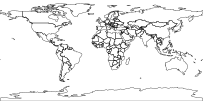

In [19]:
#Load some data about the world's countries
worldshapefile="ne_110m_admin_0_countries.shp"
dl("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/110m_cultural/ne_110m_admin_0_countries.shp", worldshapefile)
worldshape = open(worldshapefile) do f
      read(f, Shapefile.Handle)
end
world=compose(context(), fill(nothing), stroke(colorant"black"), Polygons(worldshape.shapes)...)
draw(SVG(8inch, 4inch), compose(context(units=UnitBox(-180, 90, 360, -180)), world))

Next, let's place everyone on the map.

For a given user, we retrieve their reported location on GitHub using `GitHub.user` and look it up on a geocoding service. Here we use [OpenStreetMap's Nominatim](http://wiki.openstreetmap.org/wiki/Nominatim) service to look up a list of candidate locations, and return the first location as a tuple of latitude, longitude and location name. If there are no candidate locations, return `nothing`.

Since we don't have a nice wrapper around Nominatim like we do for GitHub, we have to do all the error handling ourselves. (Note: There is currently a bug in Julia's web stack which makes this code not work for querying locations with non-ASCII characters in them.)

In [20]:
function getlatlon(username, my_auth=my_auth)
    userdata = bytestring(user(username, auth=my_auth))
    location = JSON.parse(userdata)["location"] #Get user location from GitHub
    location == nothing && return nothing    #Location was missing
    strip(location) == "" && return nothing  #Location was missing
    
    #Take location and look up on geocoding service
    try
        responseosm = get("http://nominatim.openstreetmap.org/search",
            query=@compat Dict("format"=>"json", "q"=>location))
        osmdata = bytestring(responseosm.data)
        if responseosm.status!=200 && contains(responseosm.headers["Content-Type"], "text/html")
            display("text/html", osmdata)
        end
        meosm = JSON.parse(osmdata)
        if length(meosm)<1
            warn("OpenStreetMaps did not know the location of user $username with reported location $location")
            return (Inf, Inf, nothing) #Geocoder doesn't know where this is
        end
        #Return the first hit
        return (float(meosm[1]["lat"]), float(meosm[1]["lon"]), location)
    catch e
        warn("Ignoring bad response from URL: http://nominatim.openstreetmap.org/search?format=json&q=$location")
        println("Error caught: ", e)
        if isdefined(:responseosm)
            if contains(responseosm.headers["Content-Type"], "text/html")
                display("text/html", osmdata)
            else
                println(osmdata)
            end
        end
        return nothing
    end
end

getlatlon (generic function with 2 methods)

Now define a function to iterate over a list of authors and add their locations to a `locations` dictionary.

In [21]:
function adduserlocations!(locations::Dict, authors)
    @showprogress for user in authors
        if isa(user, HttpCommon.Response)
            user = JSON.parse(bytestring(user.data))
        end
        username = if isa(user, Dict)
            user["author"].login
        elseif isa(user, User)
            user.login
        else
            throw(ValueError("Unknown type of user: $(typeof(user))"))
        end
        haskey(locations, username) && continue #Don't look up existing data again
        location = getlatlon(username, my_auth)
        location===nothing && continue
        locations[username] = location
    end
end
isdefined(:locations) || (locations=Dict())
adduserlocations!(locations, authors)

Progress:   3%|█                                        |  ETA: 0:17:09

Progress:  14%|██████                                   |  ETA: 0:10:46

Progress:  30%|████████████                             |  ETA: 0:09:29

Progress:  32%|█████████████                            |  ETA: 0:09:09

Progress:  42%|█████████████████                        |  ETA: 0:07:55

Progress:  65%|███████████████████████████              |  ETA: 0:04:23

Progress:  69%|████████████████████████████             |  ETA: 0:03:53

Progress:  81%|█████████████████████████████████        |  ETA: 0:02:21

Progress: 100%|█████████████████████████████████████████| Time: 0:12:16


Finally we have all the data necessary to render user locations as dots on the world map. We use here a dot size that grows slowly with the number of contributions.

In [22]:
#Render developers
function placeauthors(authors)
    xs = Float64[]; ys=Float64[]; rs=Any[]
    @showprogress for user in authors
        if isa(user, HttpCommon.Response)
            user = JSON.parse(bytestring(user.data))
        end
        username, n = if isa(user, Dict)
            user["author"].login, user["contributions"]
        elseif isa(user, User)
            user.login, 1
        else
            throw(ValueError("Unknown type of user: $(typeof(user))"))
        end
        haskey(locations, username) || continue
        (isnan(locations[username][1]) || isnan(locations[username][2])) && continue
        push!(xs, locations[username][2])
        push!(ys, locations[username][1])
        push!(rs, (1+√log(n))*0.3mm)
    end
    circle(xs, ys, rs)
end

function drawmap(left::Real=-180, right::Real=180, up::Real=90, down::Real=-90,
        composeobjs...)
    draw(SVG(4inch*(right-left)/(up-down),4inch),
    compose(context(units=UnitBox(left,up,right-left,down-up)), world, composeobjs...))

    #Print users in the box
    #for (user, loc) in locations
    #    if down<loc[1]<up && left<loc[2]<right
    #        println(user, ":", loc)
    #    end
    #end
end

drawmap (generic function with 5 methods)

Finally, we are ready to plot all the Julia contributors on a world map!

Progress:   6%|██                                       |  ETA: 0:00:00

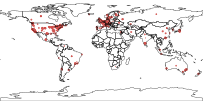

In [23]:
devs=compose(context(), fill(colorant"#d66661"), stroke(colorant"#c93d39"), linewidth(0.3mm),
        placeauthors(authors))

drawmap(-180, 180, 90, -90, devs)

Using `Interact.@manipulate`, we can make a simple zoomable map with very little effort:

Interact.Slider{Int64}([Reactive.Input{Int64}] 0,"limit_east",0,-180:180)

Interact.Slider{Int64}([Reactive.Input{Int64}] 90,"limit_west",90,0:180)

Interact.Slider{Int64}([Reactive.Input{Int64}] 0,"limit_north",0,-90:90)

Interact.Slider{Int64}([Reactive.Input{Int64}] -45,"limit_south",-45,-90:0)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


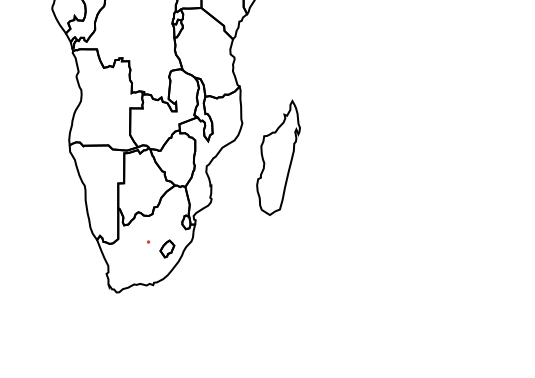

In [24]:
@manipulate for limit_east=-180:180, limit_west=limit_east.value:180, limit_north=-90:90, limit_south=-90:limit_north.value
    left = limit_east
    right = limit_west
    up = limit_north
    down = limit_south
    box = UnitBox(left, up, right-left, down-up)
    compose(context(units=box), world, devs)
end

## Stargazers and watchers

We can also retrieve similar data for stargazers and watchers.

In [ ]:
# Get stargazers
juliastargazers = stargazers("JuliaLang", "julia", auth=my_auth)
adduserlocations!(locations, juliastargazers)
# Get watchers
juliawatchers = watchers("JuliaLang", "julia", auth=my_auth)
adduserlocations!(locations, juliawatchers)

In [ ]:
#Render stargazers and watches
stars=compose(context(), fill(nothing), stroke("#945bb0"),
    placeauthors(juliastargazers))

watches=compose(context(), fill("#6bab5b"),
    placeauthors(juliawatchers));

drawmap(-180, 180, 90, -90, devs, stars, watches)

In [ ]:
@manipulate for limit_east=-180:180, limit_west=limit_east.value:180, limit_north=-90:90, limit_south=-90:limit_north.value
    left = limit_east
    right = limit_west
    up = limit_north
    down = limit_south
    box = UnitBox(left, up, right-left, down-up)
    compose(context(units=box), world, devs, stars, watches)
end

# Save data

Finally, we can save all the data we have painstakingly collected using `HDF5.JLD.save`, so that we may use it in further analysis.

In [ ]:
save("worldofjulia.jld",
        "allcontributors", authors,
        "juliacontributors", juliacontributors,
        "juliastargazers", juliastargazers, 
        "juliawatchers", juliawatchers,
        "locations", locations
)